In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

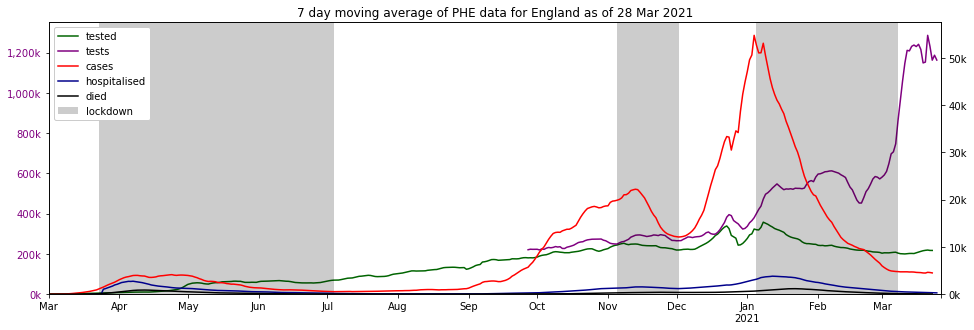

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

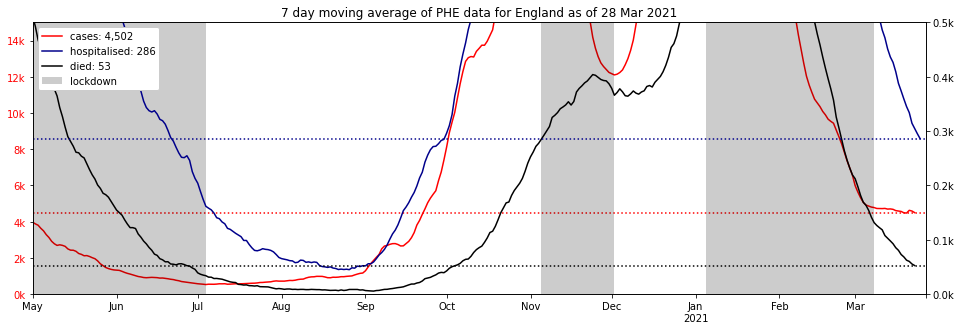

In [3]:
plot_summary(earliest_date='2020-05-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=15_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=500)

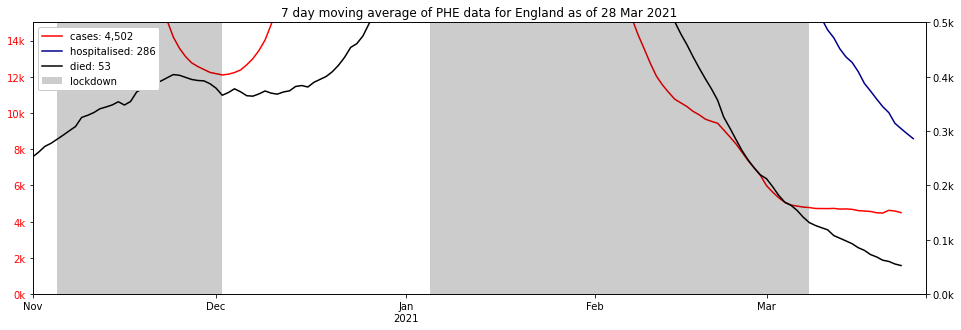

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=15_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=500)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,2679046.0,25651406.0,22972360.0,56286961,4.759621,40.812934,54.427445
1,Northern Ireland,N92000002,123452.0,726589.0,603137.0,1893667,6.519203,31.850214,61.630582
2,Scotland,S92000003,312320.0,2385709.0,2073389.0,5463300,5.716691,37.951220,56.332089
3,Wales,W92000004,412663.0,1387583.0,974920.0,3152879,13.088450,30.921580,55.989970


'partial: 30,151,287 (45.1%), full: 3,527,481'

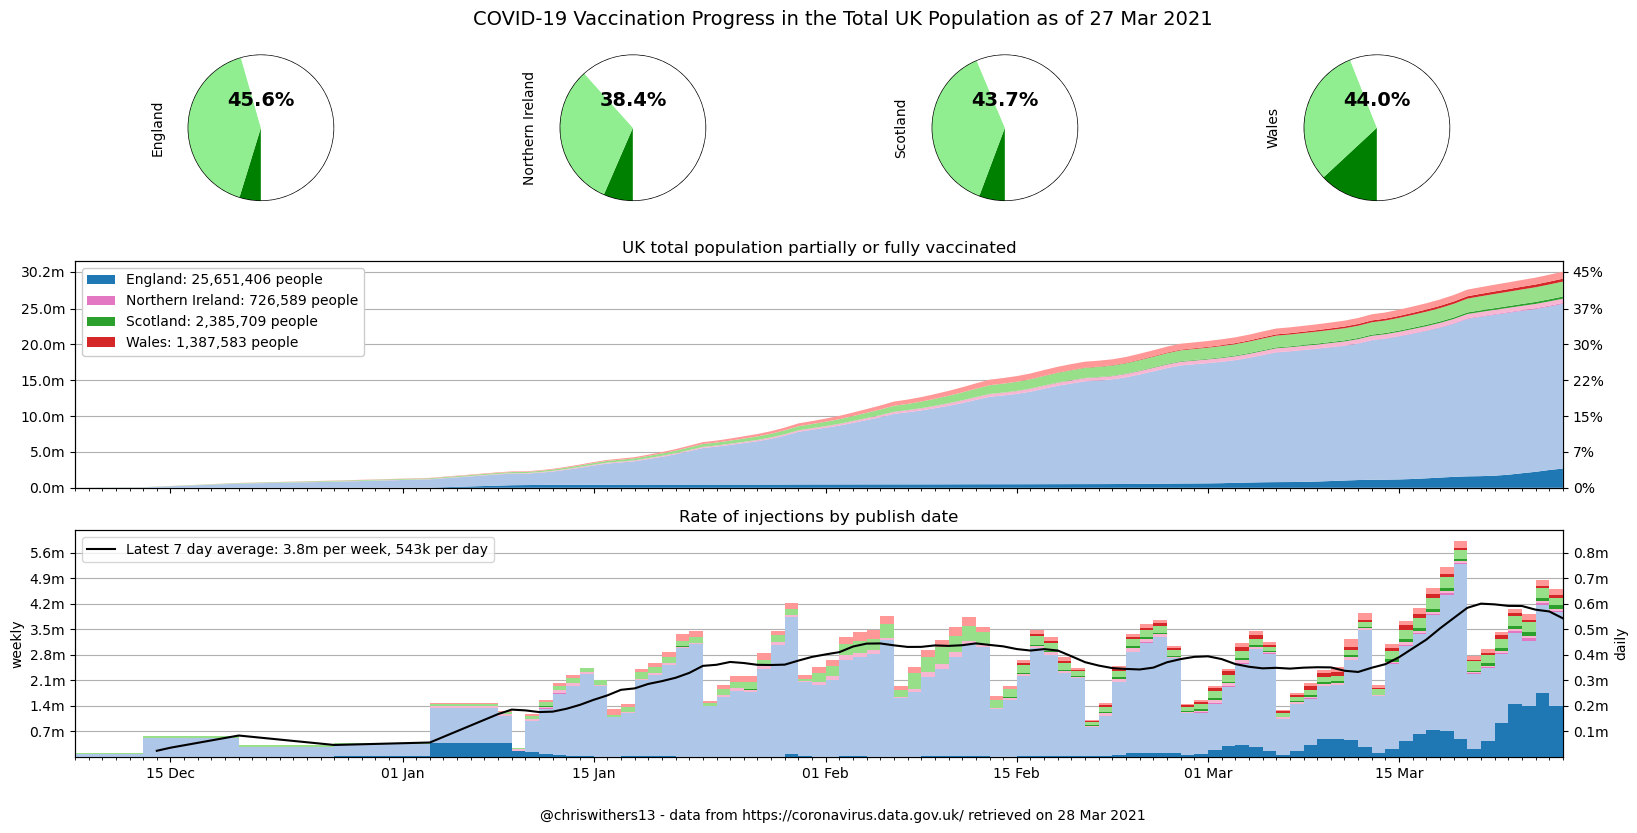

In [5]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [6]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,27 Mar 21,"+367,393","+201,335","+201,335","+25,651,406","+2,679,046","+2,679,046"
Northern Ireland,27 Mar 21,"+7,329","+3,103","+3,103","+726,589","+123,452","+123,452"
Scotland,27 Mar 21,"+26,902","+17,606","+17,606","+2,385,709","+312,320","+312,320"
Wales,27 Mar 21,"+22,228","+11,920","+11,920","+1,387,583","+412,663","+412,663"


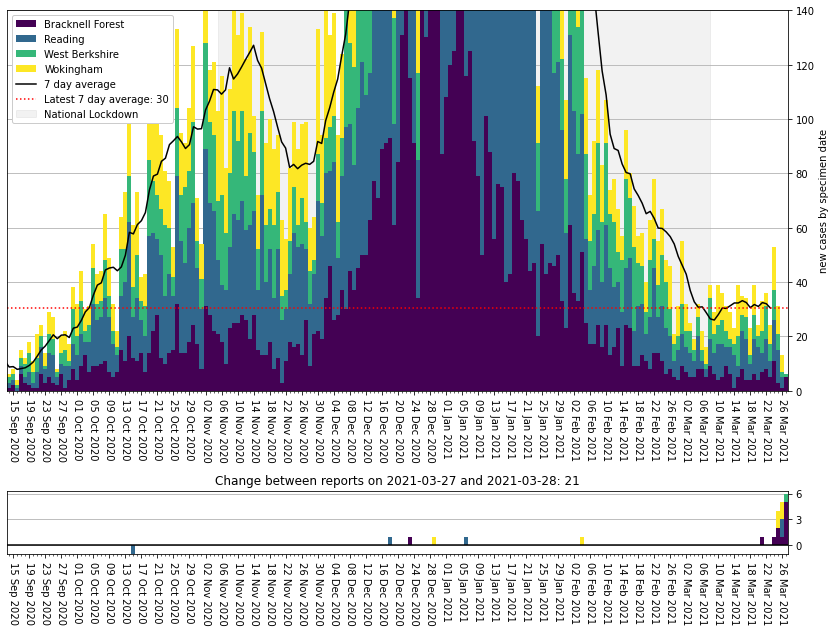

In [7]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

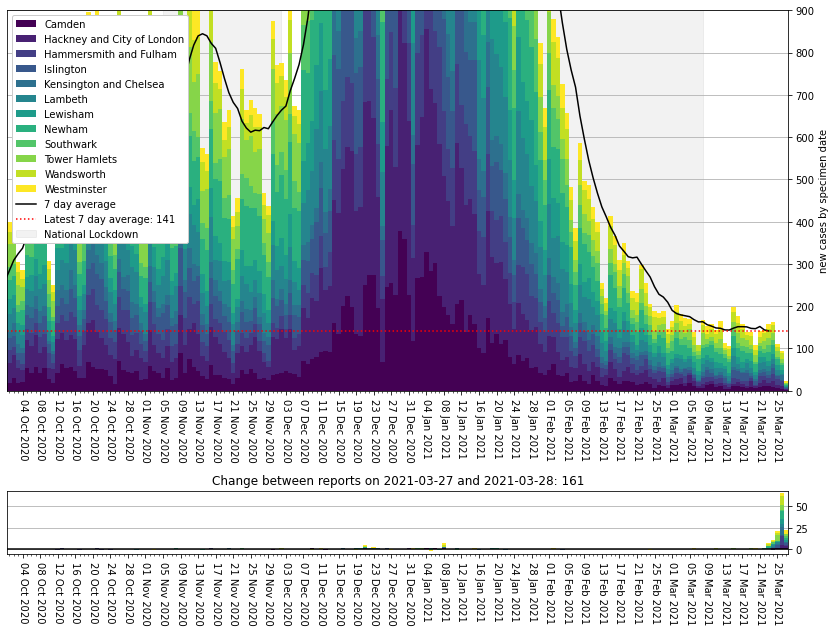

In [8]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [9]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [10]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,193.857487,140.0,2021-03-27
E08000018,Rotherham,158.245137,420.0,2021-03-27
E07000218,North Warwickshire,156.288306,102.0,2021-03-27
S12000040,West Lothian,147.460404,270.0,2021-03-27
E06000013,North Lincolnshire,134.074710,231.0,2021-03-27
E08000016,Barnsley,132.460525,327.0,2021-03-27
S12000050,North Lanarkshire,130.650028,446.0,2021-03-27
E08000017,Doncaster,130.174100,406.0,2021-03-27
N09000009,Mid Ulster,127.248734,189.0,2021-03-27


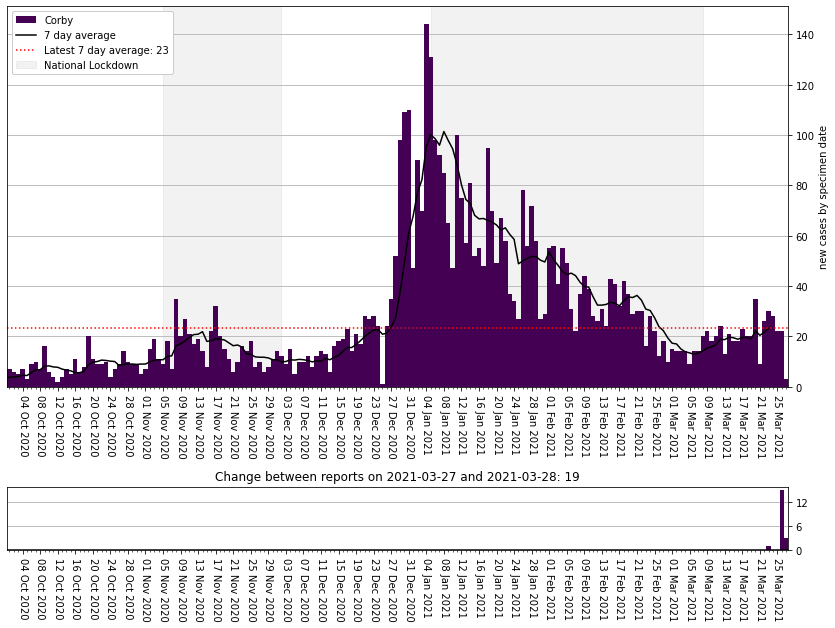

In [11]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [12]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,104.143158,826.0,2021-03-27
E08000025,Birmingham,64.896621,741.0,2021-03-27
E08000032,Bradford,123.755039,668.0,2021-03-27
E08000019,Sheffield,109.429207,640.0,2021-03-27
S12000049,Glasgow City,89.082638,564.0,2021-03-27
E08000003,Manchester,84.470153,467.0,2021-03-27
S12000050,North Lanarkshire,130.650028,446.0,2021-03-27
E08000034,Kirklees,97.547222,429.0,2021-03-27
E08000036,Wakefield,122.017042,425.0,2021-03-27


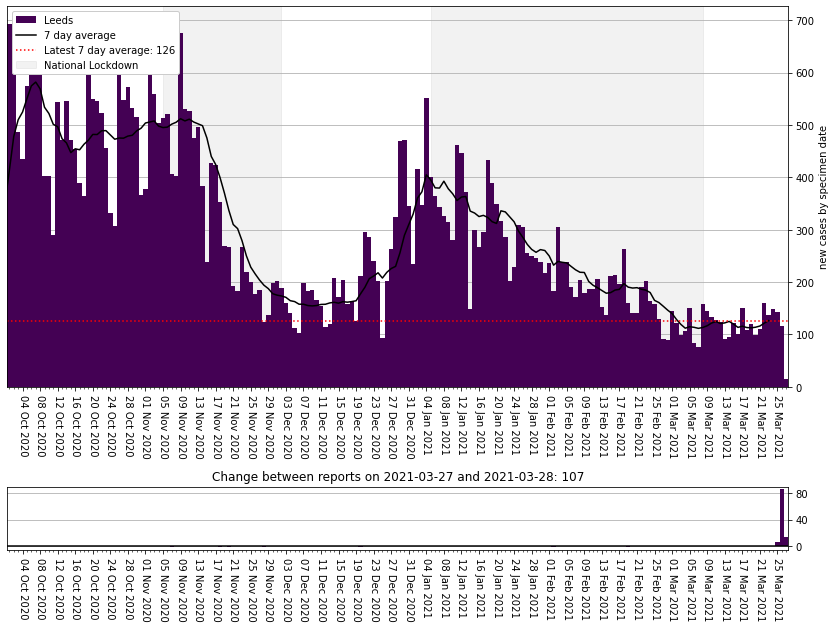

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.25

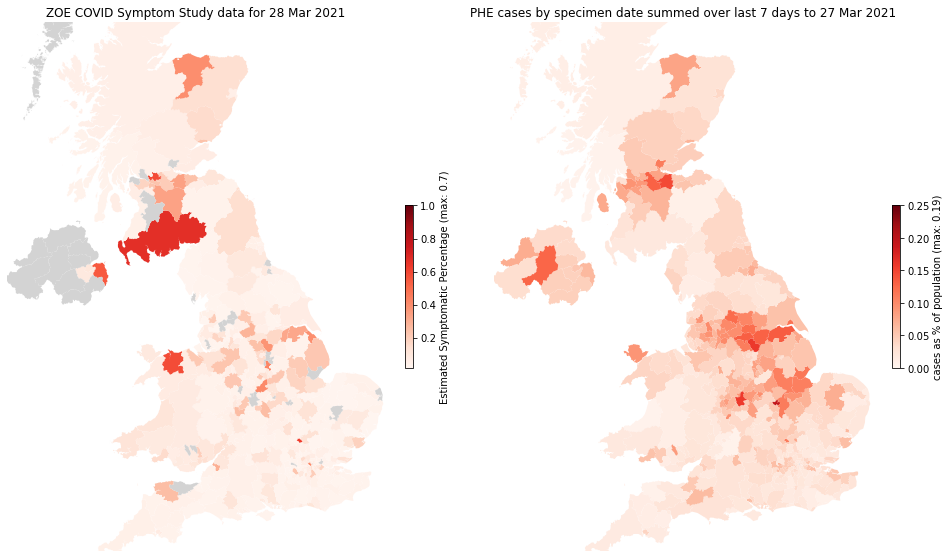

In [15]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [16]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

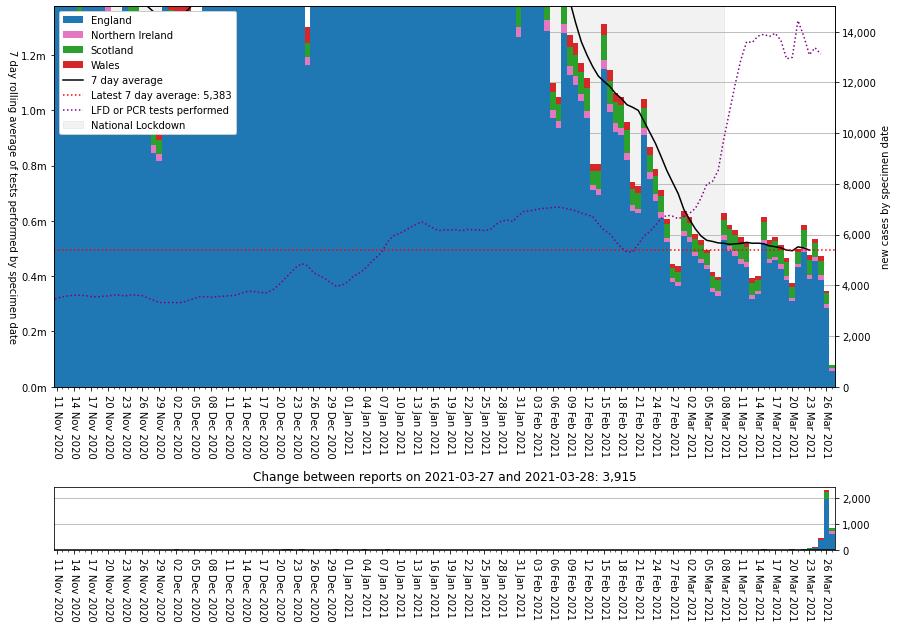

In [17]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')